In [1]:
# User-defined variables
work_dir = '/Users/Tem/Documents/naturalistic-threat-ptsd'
nPerms = 10000
trim_TRs = 4 #number of TRs to trim from beginning and end of functional scan (separate from hemodynamic adjustment)

In [2]:
# Import packages
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import levene, mannwhitneyu
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import iqr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from datetime import datetime
import random
from sklearn.metrics import pairwise_distances
from scipy.stats import rankdata
from nltools.data import Adjacency
from statsmodels.stats.multitest import fdrcorrection
from matplotlib import gridspec

In [3]:
# Create directory to house naturalistic figures
date_string = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
naturalistic_fig_dir = f"{work_dir}/data/figures/naturalistic-figs-{date_string}"
os.makedirs(naturalistic_fig_dir)

In [4]:
# Load movie metadata 
movie_metadata = pd.read_csv(f"{work_dir}/data/task/stim-metadata-naturalistic.csv") 
movie_metadata['Start_TR'][0] = movie_metadata['Start_TR'][0] + trim_TRs
movie_metadata['Stop_TR'][len(movie_metadata) - 1] = movie_metadata['Stop_TR'][len(movie_metadata) - 1] - trim_TRs
movie_metadata['Scene_Length'] = movie_metadata['Stop_TR'] - movie_metadata['Start_TR']

nScenes = len(movie_metadata)
movie_TRs = [list(range(movie_metadata['Start_TR'][i], movie_metadata['Stop_TR'][i])) for i in range(0, nScenes)]

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'Re-experiencing'),
  Text(1.5, 0, 'Avoidance-Numbing'),
  Text(2.5, 0, 'Hyperarousal')])

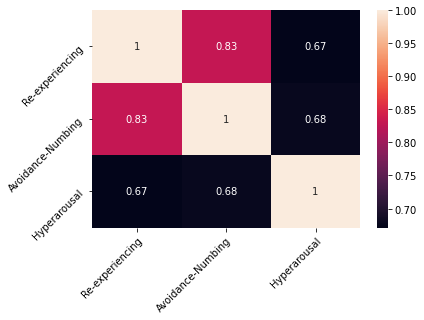

In [5]:
# Load ROI labels
amygdala_labels = pd.read_csv(f"{work_dir}/masks/amygdala-harvard-oxford/ROI-labels.csv")

# Load and visualize symptom data
CAPS_data = pd.read_csv(f"{work_dir}/data/subs/CAPS.csv")
nCohort = len(CAPS_data)

symptom_labels = ['Re-experiencing', 'Avoidance-Numbing', 'Hyperarousal']

sns.heatmap(np.corrcoef(CAPS_data[symptom_labels].to_numpy(), rowvar = False), 
            xticklabels = symptom_labels,
            yticklabels = symptom_labels,
            annot = True)

plt.yticks(rotation = 45)
plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right')

## Functions

In [6]:
# Define function that calculates spatial interSC
def calc_spatial_interSC(group_data):

    nGroup = group_data.shape[2]
    
    group_ByScene = np.zeros((nVoxels, nScenes, nGroup))

    for i in range(0, nScenes):
        scene_TRs = (movie_TRs[i])
        scene_TRs = [x - 1 for x in scene_TRs] 
        group_ByScene[:,i,:] = np.mean(group_data[:, scene_TRs, :], axis = 1)
    
    subs = np.arange(0, nGroup)
    group_heldout = np.zeros((nVoxels, nScenes, nGroup))
    
    for i in subs:
        sel_subs = subs[subs!= i]
        group_heldout[:, :, i] = np.mean(group_ByScene[:, :, sel_subs], axis = 2)
    
    if shuffle == 1:
        shuff_scene = list(range(nScenes))
        random.shuffle(shuff_scene)
        group_ByScene = group_ByScene[:, shuff_scene, :] 
        
    full_interSC_group = np.zeros((nScenes, nGroup))
    group_median_nonmatch = np.zeros(nGroup)

    diag_mask = np.ones((nScenes, nScenes), dtype = bool)
    np.fill_diagonal(diag_mask, False)
    div_by = len(diag_mask)

    for i in range(nGroup):
        sub_mat = np.corrcoef(group_ByScene[:,:,i], group_heldout[:,:,i], rowvar = False)
        sub_mat = sub_mat[div_by:, :div_by]
        full_interSC_group[:, i] = np.diagonal(sub_mat)
        group_median_nonmatch[i] = np.median(sub_mat[diag_mask])
    
    return full_interSC_group, group_ByScene, group_median_nonmatch

In [7]:
# Define function that correlates an interSC variable with each dimension of a symptom variable
def corr_isc_symp(interSC_var, symp_var): 
    
    actual_corrs = [None] * len(symptom_labels)
    corr_p_vals = [None] * len(symptom_labels)
    all_null_dists = [None] * len(symptom_labels)
    
    for i in range(len(symptom_labels)):
        
        which_score = symptom_labels[i]
        null_dist = np.zeros(nPerms)

        # Actual r value
        x = symp_var[which_score]
        y = interSC_var
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        actual_corr = stats.spearmanr(x[~nas], y[~nas])[0]
        actual_corrs[i] = actual_corr

        # Null dist of r-values 
        for j in range(nPerms):
            x = symp_var[which_score]
            y = interSC_var[random.choices(range(nCohort), k = (nCohort))]
            nas = np.logical_or(np.isnan(x), np.isnan(y))
            null_dist[j] = stats.spearmanr(x[~nas], y[~nas])[0]
    
        perms_above_frac = len((null_dist[null_dist > actual_corr]) + 1) / (nPerms + 1)
        corr_p_vals[i] = min(2*perms_above_frac, 2*(1-perms_above_frac))
        all_null_dists[i] = null_dist
        
    return actual_corrs, corr_p_vals, all_null_dists

## Matching vs. Non-Matching Scene InterSC

In [8]:
# Create lists to store matching vs. non-matching (MvNM) scene data
ROI_MvNM_labels = ['L. Amygdala', 'R. Amygdala']
ROI_MvNM_nulls = []
ROI_MvNM_actuals = []
ROI_MvNM_p_vals = []

In [9]:
# Compute left amygdala interSC and p-value
shuffle = 0
LA_data = np.load(work_dir + '/data/neural-naturalistic/amygdala-harvard-oxford-6mm/HO_1_6mm_data.npy')
nVoxels = LA_data.shape[0]
LA_full_interSC, LA_ByScene, LA_nonmatch = calc_spatial_interSC(LA_data)
LA_interSC = np.median(LA_full_interSC, axis = 0)

actual_diff = np.median(LA_interSC - LA_nonmatch)
null_dist_diff = np.zeros(nPerms)

shuffle = 1

for k in range(nPerms):
    shuff_LA_full_interSC, shuff_LA_ByScene, shuff_LA_nonmatch = calc_spatial_interSC(LA_data)
    shuff_LA_interSC = np.median(shuff_LA_full_interSC, axis = 0)
    
    null_dist_diff[k] = np.median(shuff_LA_interSC - shuff_LA_nonmatch)
    perms_above_frac = (len(null_dist_diff[null_dist_diff > actual_diff]) + 1) / (nPerms + 1)
    p_val_diff = min(2*perms_above_frac, 2*(1-perms_above_frac))

print(f"Diff p-val: {p_val_diff}")

ROI_MvNM_nulls.append(null_dist_diff)
ROI_MvNM_actuals.append(actual_diff)
ROI_MvNM_p_vals.append(p_val_diff)

Diff p-val: 0.5


In [10]:
# Compute right amygdala interSC and p-value
shuffle = 0
RA_data = np.load(work_dir + '/data/neural-naturalistic/amygdala-harvard-oxford-6mm/HO_2_6mm_data.npy')
nVoxels = RA_data.shape[0]
RA_full_interSC, RA_ByScene, RA_nonmatch = calc_spatial_interSC(RA_data)
RA_interSC = np.median(RA_full_interSC, axis = 0)

actual_diff = np.median(RA_interSC - RA_nonmatch)
null_dist_diff = np.zeros(nPerms)

shuffle = 1

for k in range(nPerms):
    shuff_RA_full_interSC, shuff_RA_ByScene, shuff_RA_nonmatch = calc_spatial_interSC(RA_data)
    shuff_RA_interSC = np.median(shuff_RA_full_interSC, axis = 0)
    
    null_dist_diff[k] = np.median(shuff_RA_interSC - shuff_RA_nonmatch)
    
    perms_above_frac = (len(null_dist_diff[null_dist_diff > actual_diff]) + 1) / (nPerms + 1)
    p_val_diff = min(2*perms_above_frac, 2*(1-perms_above_frac))

print(f"Diff p-val: {p_val_diff}")

ROI_MvNM_nulls.append(null_dist_diff)
ROI_MvNM_actuals.append(actual_diff)
ROI_MvNM_p_vals.append(p_val_diff)

Diff p-val: 0.5


In [11]:
# Assemble data into pandas dataframes
LA_MvNM_data = pd.DataFrame({'InterSC': list(LA_interSC) + list(LA_nonmatch),
                             'ROI': ['L. Amyg'] * (len(LA_interSC)*2),
                             'Scene Type': ['Matching'] * len(LA_interSC) + ['Non-Matching'] * len(LA_nonmatch)})

RA_MvNM_data = pd.DataFrame({'InterSC': list(RA_interSC) + list(RA_nonmatch),
                             'ROI': ['R. Amyg'] * (len(RA_interSC)*2),
                             'Scene Type': ['Matching'] * len(RA_interSC) + ['Non-Matching'] * len(RA_nonmatch)})


ROI_MvNM_data = pd.concat([LA_MvNM_data, RA_MvNM_data])
ROI_MvNM_p_corrected = fdrcorrection(ROI_MvNM_p_vals)[1]

In [12]:
# Calculate medians and IQRs for matching scenes
LA_iqr = iqr(LA_interSC)
RA_iqr = iqr(RA_interSC)

print('Left Amygdala')
print(f"median: {np.median(LA_interSC)}")
print(f"iqr: {LA_iqr}")

print('\nRight Amygdala')
print(f"median: {np.median(RA_interSC)}")
print(f"iqr: {RA_iqr}")

Left Amygdala
median: 0.024426294683374105
iqr: 0.10966249190506668

Right Amygdala
median: 0.03491742076355462
iqr: 0.09397745920866564


In [13]:
# Calculate medians and IQRs for non-matching scenes
LA_nonmatch_iqr = iqr(LA_nonmatch)
RA_nonmatch_iqr = iqr(RA_nonmatch)

print('Left Amygdala')
print(f"median: {np.median(LA_nonmatch)}")
print(f"iqr: {LA_nonmatch_iqr}")

print('\nRight Amygdala')
print(f"median: {np.median(RA_nonmatch)}")
print(f"iqr: {RA_nonmatch_iqr}")

Left Amygdala
median: -0.0005104790833670201
iqr: 0.00851134038542019

Right Amygdala
median: -0.0010102242526798672
iqr: 0.007828717314544629


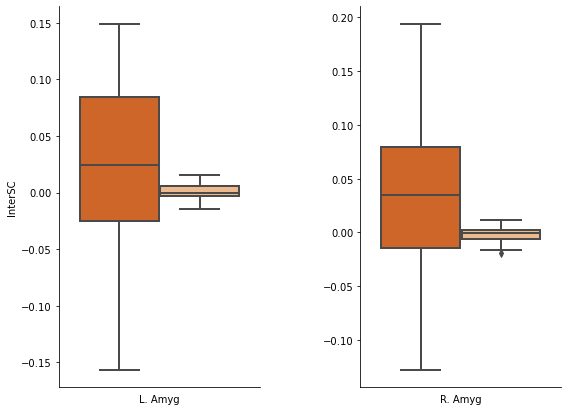

In [14]:
# Plot matching vs. non-matching interSC by ROI
f = plt.figure(figsize = (9, 7))
f.subplots_adjust(wspace = 0.5)

plt.subplot(121)
ax = sns.boxplot(data = LA_MvNM_data, 
            x = 'ROI', 
            y = 'InterSC', 
            hue = 'Scene Type', 
            linewidth = 2,
            palette = 'Oranges_r')

plt.xlabel(None)
ax.tick_params(bottom = False)
plt.legend([],[], frameon = False)


plt.subplot(122)
ax2 = sns.boxplot(data = RA_MvNM_data, 
            x = 'ROI', 
            y = 'InterSC', 
            hue = 'Scene Type', 
            linewidth = 2,
            palette = 'Oranges_r')

plt.xlabel(None)
plt.ylabel(None)
ax2.tick_params(bottom = False)
plt.legend([],[], frameon = False)
sns.despine()

plt.savefig(f"{naturalistic_fig_dir}/MvNM_isc.png")

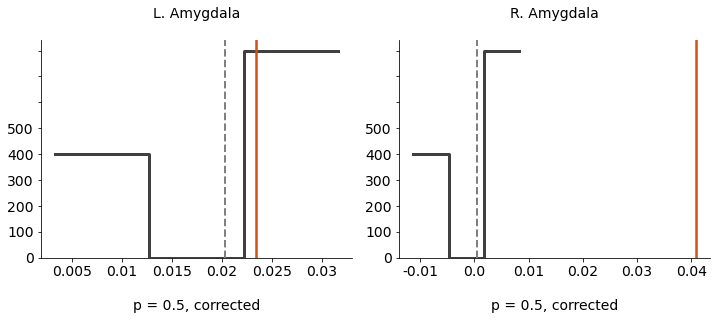

In [15]:
# Plot matching vs non-matching interSC difference against null distribution 
f = plt.figure(figsize=(12, 4))
f.subplots_adjust(wspace = 0.15)

plt.subplot(121)
ax1 = sns.histplot(data = ROI_MvNM_nulls[0], color = '0.25', element = "step", fill = False, linewidth = 3)
plt.title(f"{ROI_MvNM_labels[0]}\n", fontsize = 14)
plt.ylabel(None)
plt.xlabel(f"\np = {np.round(ROI_MvNM_p_corrected[0], 5)}, corrected", fontsize = 14)
plt.axvline(ROI_MvNM_actuals[0], color = '#CE5214', linewidth = 2.5)
plt.axvline(np.mean(ROI_MvNM_nulls[0]), color = '0.5', linestyle = 'dashed', linewidth = 2)
ax1.set_yticklabels([0, 100, 200, 300, 400, 500], size = 14)
ax1.set_xticklabels(np.round(ax1.get_xticks(), 3), size = 14)

plt.subplot(122)
ax2 = sns.histplot(data = ROI_MvNM_nulls[1], color = '0.25', element = "step", fill = False, linewidth = 3)
plt.title(f"{ROI_MvNM_labels[1]}\n", fontsize = 14)
plt.ylabel(None)
plt.xlabel(f"\np = {np.round(ROI_MvNM_p_corrected[1], 5)}, corrected", fontsize = 14)
plt.axvline(ROI_MvNM_actuals[1], color = '#CE5214', linewidth = 2.5)
plt.axvline(np.mean(ROI_MvNM_nulls[1]), color = '0.5', linestyle = 'dashed', linewidth = 2)
ax2.set_yticklabels([0, 100, 200, 300, 400, 500], size = 14)
ax2.set_xticklabels(np.round(ax2.get_xticks(), 3), size = 14)

sns.despine()

plt.savefig(f"{naturalistic_fig_dir}/isc_histograms.png")

## Left Amygdala InterSC vs. Symptom Severity

In [16]:
# Run Spearman correlations between left amygdala interSC and each CAPS dimension
print('Left Amygdala Spatial InterSC vs. Symptoms \n')
nVoxels, nTRs, nCohort = LA_data.shape
LA_spatial_r_vals, LA_spatial_p_vals, LA_spatial_nulls =  corr_isc_symp(LA_interSC, CAPS_data)
LA_spatial_p_corrected = fdrcorrection(LA_spatial_p_vals)[1]

summary = pd.DataFrame()
summary['score'] = symptom_labels
summary['r_vals'] = LA_spatial_r_vals
summary['p_vals'] = LA_spatial_p_vals
summary['p_corrected'] = LA_spatial_p_corrected
print(summary.to_string())

Left Amygdala Spatial InterSC vs. Symptoms 

               score    r_vals  p_vals  p_corrected
0    Re-experiencing -0.245661     0.5          0.5
1  Avoidance-Numbing -0.060212     0.5          0.5
2       Hyperarousal -0.437373     0.5          0.5


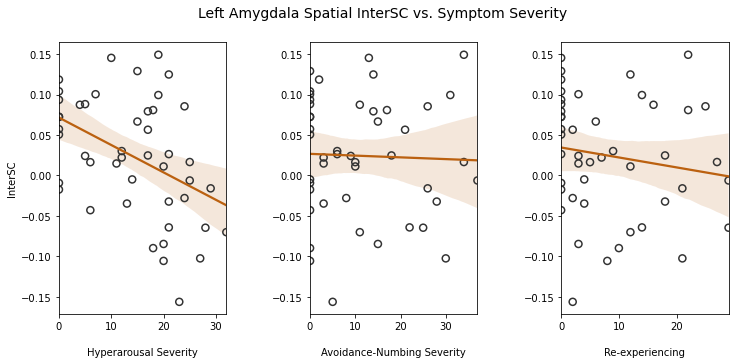

In [17]:
# Plot interSC vs. symptom severity for each CAPS dimension
f = plt.figure(figsize=(12, 5))
f.suptitle('Left Amygdala Spatial InterSC vs. Symptom Severity', fontsize = 14)
plt.subplots_adjust(wspace=0.5, hspace=0.25)

ax1 = plt.subplot(131)
x = CAPS_data['Hyperarousal']
y = LA_interSC

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#BB6110"}).set(xlabel = '\nHyperarousal Severity')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)
plt.ylabel('InterSC')

ax2 = plt.subplot(132, sharey = ax1)
x = CAPS_data['Avoidance-Numbing']
y = LA_interSC

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#BB6110"}).set(xlabel = '\nAvoidance-Numbing Severity')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)

ax3 = plt.subplot(133, sharey = ax1)
x = CAPS_data['Re-experiencing']
y = LA_interSC

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#BB6110"}).set(xlabel = '\nRe-experiencing')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)

plt.savefig(f"{naturalistic_fig_dir}/symptom_correlations.png")


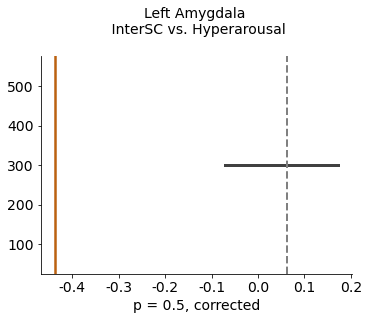

In [18]:
# Plot null distribution of Spearman coefficients (interSC vs. hyperarousal only)
f = plt.figure(figsize=(12, 4))
f.subplots_adjust(wspace = 0.15)

plt.subplot(121)
ax = sns.histplot(data = LA_spatial_nulls[2], color = '0.25', element = "step", fill = False, linewidth = 3)
plt.title(f"Left Amygdala \n InterSC vs. {symptom_labels[2]}\n", fontsize = 14)
plt.xlabel(f"p = {np.round(LA_spatial_p_corrected[2], 5)}, corrected", fontsize = 14)
plt.axvline(LA_spatial_r_vals[2], color = "#BB6110", linewidth = 2.5)
plt.axvline(np.mean(LA_spatial_nulls[2]), color = '0.5', linestyle = 'dashed', linewidth = 2)
ax.set_yticklabels([0, 100, 200, 300, 400, 500], size = 14)
ax.set_xticklabels(np.round(ax.get_xticks(), 3), size = 14)
plt.ylabel(None)
sns.despine()

plt.savefig(f"{naturalistic_fig_dir}/hyperarousal_histogram.png")

# Left Amygdala InterSC by Valence

In [19]:
# Recalculate interSC for neutral scenes and negative scenes separately
print('InterSC vs. Symptom Left Amygdala Results by Valence')
neu_scenes = (movie_metadata['rMode_Counts'] > 3) & (movie_metadata['rMode'] == 3)
neg_scenes = (movie_metadata['rMode_Counts'] > 3) & (movie_metadata['rMode'] > 3)

neu_isc = np.median(LA_full_interSC[neu_scenes], axis = 0)
neg_isc = np.median(LA_full_interSC[neg_scenes], axis = 0)

neu_r, neu_p, neu_null_dists = corr_isc_symp(neu_isc, CAPS_data)
neg_r, neg_p, neg_null_dists = corr_isc_symp(neg_isc, CAPS_data)

summary = pd.DataFrame()
summary['score'] = symptom_labels
summary['neu_p'] = neu_p
summary['neg_p'] = neg_p
summary['neu_r'] = neu_r
summary['neg_r'] = neg_r

summary = summary[summary['score'].str.match('Hyperarousal')]
summary

InterSC vs. Symptom Left Amygdala Results by Valence


,score,neu_p,neg_p,neu_r,neg_r
2,Hyperarousal,0.5,0.5,-0.23467,-0.459675


In [20]:
# Recalculate interSC vs. hyperarousal severity for neutral scenes and negative scenes separately
valence_hyp_p_corrected = fdrcorrection([summary['neu_p'][2], summary['neg_p'][2]])
neu_hyp_p_corrected = np.round(valence_hyp_p_corrected[1][0], 5)
neg_hyp_p_corrected = np.round(valence_hyp_p_corrected[1][1], 5)

# Calculate difference in r value for negative and neutral scenes
hyp_neg_r = summary['neg_r'][2]
hyp_neu_r = summary['neu_r'][2]
actual_val_diff = hyp_neg_r - hyp_neu_r

# Generate null distribution of r differences 
val_scenes = (movie_metadata['rMode_Counts'] > 3) & (movie_metadata['rMode'] >= 3)
nVal = val_scenes.sum()
val_null_dist = np.zeros(nPerms)

for i in range(nPerms):
    full_val_index = random.choices(range(nVal), k = (nVal))
    val_index1 = full_val_index[:neu_scenes.sum()]
    val_index2 = full_val_index[neu_scenes.sum():]

    val_shuff1 = np.median(LA_full_interSC[val_index1], axis = 0)
    val_shuff2 = np.median(LA_full_interSC[val_index2], axis = 0)

    null_r1 = (stats.spearmanr(CAPS_data['Hyperarousal'], val_shuff1)[0])
    null_r2 = (stats.spearmanr(CAPS_data['Hyperarousal'], val_shuff2)[0])

    val_null_dist[i] = null_r2 - null_r1

perms_above_frac = len((val_null_dist[val_null_dist > actual_val_diff]) + 1) / (nPerms + 1)
val_p_val = min(2*perms_above_frac, 2*(1-perms_above_frac))
val_p_val

0.5

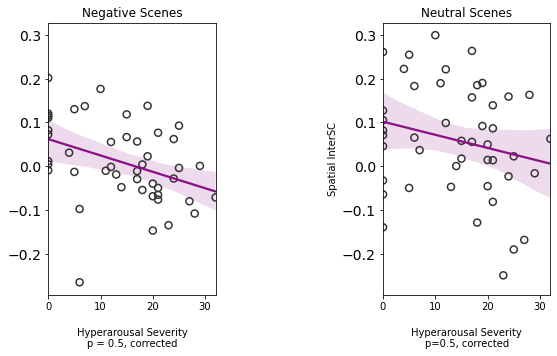

In [21]:
# Plot interSC vs. hyperarousal severity for neutral scenes and negative scenes separately
f = plt.figure(figsize=(9, 5))
f.subplots_adjust(wspace = 1)

ax1 = plt.subplot(121)
x = CAPS_data['Hyperarousal']
y = neg_isc

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#8c0e88"}).set(
    title = f"Negative Scenes", ylabel = 'InterSC', xlabel = f"\nHyperarousal Severity\np = {neg_hyp_p_corrected}, corrected")
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)
plt.yticks(fontsize = 14)
plt.ylabel(None)


ax2 = plt.subplot(122, sharey = ax1)
x = CAPS_data['Hyperarousal']
y = neu_isc

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#8c0e88"}).set(
    title = f"Neutral Scenes", ylabel = 'Spatial InterSC', xlabel = f"\nHyperarousal Severity\np={neu_hyp_p_corrected}, corrected")
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)
plt.yticks(fontsize = 14)

plt.savefig(f"{naturalistic_fig_dir}/valence.png")


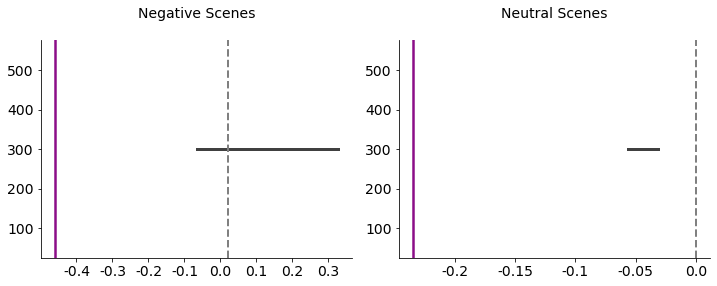

In [22]:
# Plot null distributions for neutral and negative interSC vs. hyperarousal Spearman's coefficient
f = plt.figure(figsize=(12, 4))
f.subplots_adjust(wspace = 0.15)

plt.subplot(121)
ax1 = sns.histplot(data = neg_null_dists[2], color = '0.25', element = "step", fill = False, linewidth = 3)
plt.title(f"Negative Scenes\n", fontsize = 14)
plt.ylabel(None)
plt.axvline(hyp_neg_r, color = '#8c0e88', linewidth = 2.5)
plt.axvline(np.mean(ROI_MvNM_nulls[0]), color = '0.5', linestyle = 'dashed', linewidth = 2)
ax1.set_yticklabels([0, 100, 200, 300, 400, 500], size = 14)
ax1.set_xticklabels(np.round(ax1.get_xticks(), 3), size = 14)

plt.subplot(122)
ax2 = sns.histplot(data = neu_null_dists[2], color = '0.25', element = "step", fill = False, linewidth = 3)
plt.title(f"Neutral Scenes\n", fontsize = 14)
plt.ylabel(None)
plt.axvline(hyp_neu_r, color = '#8c0e88', linewidth = 2.5)
plt.axvline(np.mean(ROI_MvNM_nulls[1]), color = '0.5', linestyle = 'dashed', linewidth = 2)
ax2.set_yticklabels([0, 100, 200, 300, 400, 500], size = 14)
ax2.set_xticklabels(np.round(ax2.get_xticks(), 3), size = 14)

sns.despine()

plt.savefig(f"{naturalistic_fig_dir}/valence_histograms.png")

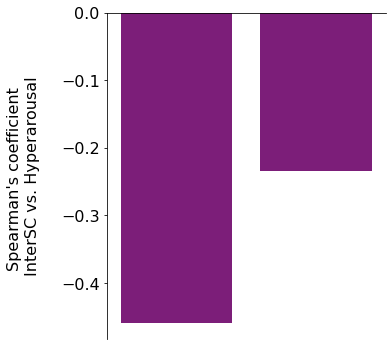

In [23]:
# Plot negative Spearman's coefficient and neutral Spearman's coefficient in bar graph
f = plt.figure(figsize=(5, 6))
x = [0.25, 0.75]
y = [hyp_neg_r, hyp_neu_r]
sns.barplot(x = x, y = y, color = "#8c0e88")
plt.xticks([])
plt.yticks(fontsize = 16)
plt.ylabel(f"Spearman's coefficient \nInterSC vs. Hyperarousal\n", fontsize = 16)
sns.despine(top = False, bottom = True)

plt.savefig(f"{naturalistic_fig_dir}/valence_pearsons.png")